# Improving Brain Tumor Segmentation in Convolutional Neural Network Models

Data set can be downloaded manually from: https://www.kaggle.com/datasets/dschettler8845/brats-2021-task1?fbclid=IwAR2VPPuNEnzJzRj-Xb4u9wSrt2F5AbJ03P6-z8c4_PA639i4Ph9Z9dE8zZQ

# Preliminary stuff

This section does the following:
1. Mounts google drive
2. Installs/Imports libraries

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!pip install nilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 26.7 MB/s eta 0:00:00


In [ ]:
import os
import glob
import random
import gc
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import nilearn as nl
import nilearn.plotting as nlplt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import to_categorical
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda, UpSampling3D, Activation
from keras.optimizers import Adam
from keras.metrics import MeanIoU
from keras.models import load_model
from keras.utils import plot_model
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import LearningRateScheduler, Callback
from sklearn.preprocessing import MinMaxScaler


# Define utils



This section defines util functions

In [ ]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128, 128), method="nearest")
    input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

    return input_image, input_mask

def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        # Random flipping of the image and mask
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image_train(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def apply_random_brightness(test_img):
    X_new = np.zeros(test_img.shape)
    for m in range(test_img.shape[-1]):
        modality = test_img[:,:,:,m]
        gain, gamma = np.random.uniform(0.8, 1.2, 2)
        modified_modality = np.sign(modality) * gain * (np.abs(modality) ** gamma)
        X_new[:, :, :, m] = modified_modality
    return X_new

In [ ]:
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

def gamma(img, mask):
    img = tf.image.adjust_gamma(img, 0.1)
    return img, mask

def crop(img, mask):
    img = tf.image.central_crop(img, 0.7)
    img = tf.image.resize(img, (192,192))
    mask = tf.image.central_crop(mask, 0.7)
    mask = tf.image.resize(mask, (192,192))
    mask = tf.cast(mask, tf.uint8)
    return img, mask

def flip_hori(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

def flip_vert(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask


# Handling the Data
Setup the data generator

In [ ]:
# Base path of folder in Colab
base_filepath = '/content/gdrive/MyDrive/DLdata/brats'

# Define which datasets to use as training and validation data
training_interval = [1, 2]
validation_interval = [11, 12]

# Define lists of training data paths
t2_list = []
t1ce_list = []
flair_list = []
mask_list = []

# Find all file paths and add to lists for training data
for i in range(training_interval[0], training_interval[1] + 1):
    dataset_path = os.path.join(base_filepath + str(i))
    t2_list += sorted(glob.glob(os.path.join(dataset_path, '*', '*t2.nii.gz')))
    t1ce_list += sorted(glob.glob(os.path.join(dataset_path, '*', '*t1ce.nii.gz')))
    flair_list += sorted(glob.glob(os.path.join(dataset_path, '*', '*flair.nii.gz')))
    mask_list += sorted(glob.glob(os.path.join(dataset_path, '*', '*seg.nii.gz')))

# Define lists of validation data paths
val_t2_list = []
val_t1ce_list = []
val_flair_list = []
val_mask_list = []

# Find all file paths and add to lists for validation data
for i in range(validation_interval[0], validation_interval[1] + 1):
    dataset_path = os.path.join(base_filepath + str(i))
    val_t2_list += sorted(glob.glob(os.path.join(dataset_path, '*', '*t2.nii.gz')))
    val_t1ce_list += sorted(glob.glob(os.path.join(dataset_path, '*', '*t1ce.nii.gz')))
    val_flair_list += sorted(glob.glob(os.path.join(dataset_path, '*', '*flair.nii.gz')))
    val_mask_list += sorted(glob.glob(os.path.join(dataset_path, '*', '*seg.nii.gz')))


In [ ]:
def load_img(img_dir, img_list):
    images = []
    for i, image_name in enumerate(img_list):
        if (isinstance(image_name, str) and '_seg' in image_name):
            mask = nib.load(image_name).get_fdata()
            # mask = mask[24:216, 24:216, 13:141]
            mask = mask[56:184, 56:184, 13:141]
            mask.astype(np.uint8)
            mask[mask==4] = 3
            mask = to_categorical(mask, num_classes=4)
            images.append(mask)

        if ('.gz' in image_name[0]):
            t2_nii  = nib.load(image_name[0]).get_fdata()
            t1ce_nii  = nib.load(image_name[1]).get_fdata()
            flair_nii  = nib.load(image_name[2]).get_fdata()

            scaler = MinMaxScaler()
            t2_nii = scaler.fit_transform(t2_nii.reshape(-1, t2_nii.shape[-1])).reshape(t2_nii.shape)
            t1ce_nii = scaler.fit_transform(t1ce_nii.reshape(-1, t1ce_nii.shape[-1])).reshape(t1ce_nii.shape)
            flair_nii = scaler.fit_transform(flair_nii.reshape(-1, flair_nii.shape[-1])).reshape(flair_nii.shape)

            image = np.stack([t2_nii, t1ce_nii, flair_nii], axis=3)
            # image = image[24:216, 24:216, 13:141]
            image = image[56:184, 56:184, 13:141]
            # image = apply_random_brightness(image)

            images.append(image)

        # Dont think this case is being used, but haven't deleted yet
        if ('.npy' in image_name[0]):
            image = np.load(img_dir + image_name)
            images.append(image)
            print("Image", i)


    images = np.array(images)
    return images


def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
    L = len(img_list)

    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X, Y)

            batch_start += batch_size
            batch_end += batch_size

            del X
            del Y
            gc.collect()
            keras.backend.clear_session()


train_img_dir = '/content/gdrive/MyDrive/DLdata/'
train_mask_dir = '/content/gdrive/MyDrive/DLdata/'
train_img_list = list(zip(t2_list,t1ce_list,flair_list))
train_mask_list = mask_list
batch_size = 2

val_img_dir = '/content/gdrive/MyDrive/DLdata/'
val_mask_dir = '/content/gdrive/MyDrive/DLdata/'
val_img_list = list(zip(val_t2_list,val_t1ce_list,val_flair_list))
val_mask_list = val_mask_list

train_img_list = list(zip(t2_list, t1ce_list, flair_list))[:100]
train_mask_list = mask_list[:100]

val_img_list = list(zip(val_t2_list, val_t1ce_list, val_flair_list))[:20]
val_mask_list = val_mask_list[:20]

train_img_datagen = imageLoader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)
val_img_datagen = imageLoader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)


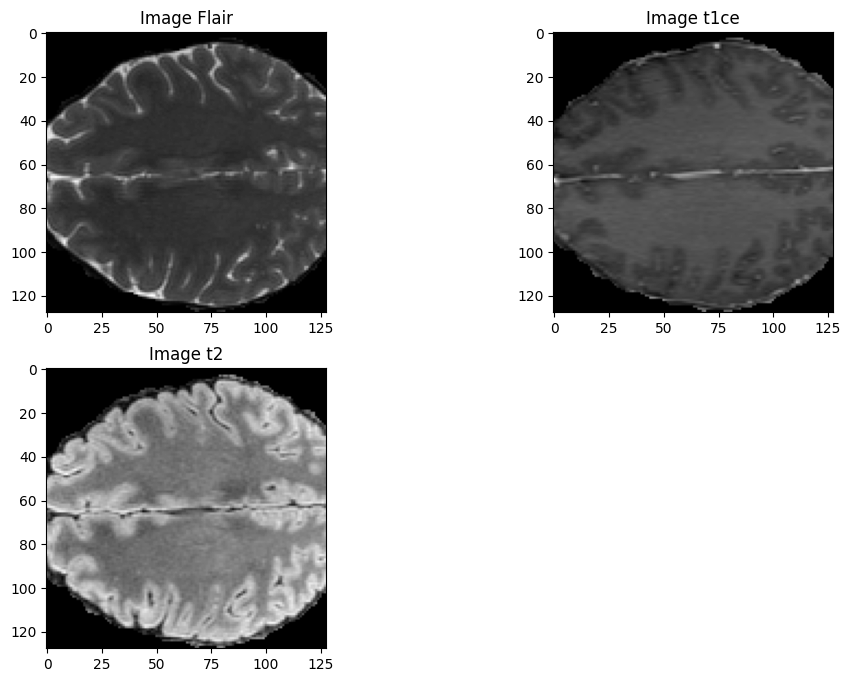

In [ ]:
img, msk = train_img_datagen.__next__()

img_num = random.randint(0, img.shape[0] - 1)
test_img = img[img_num]
test_mask = msk[img_num]
n_slice = random.randint(0, test_mask.shape[2] - 1)
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:, :, n_slice, 0], cmap='gray')
plt.title('Image Flair')
plt.subplot(222)
plt.imshow(test_img[:, :, n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:, :, n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.show()


In [ ]:
filepath = '/content/gdrive/MyDrive/DLdata/brats'

test_t2_list = []
test_t1ce_list = []
test_flair_list = []
test_mask_list = []

for i in range(7,8):
  test_t2_list = test_t2_list + sorted(glob.glob(filepath + str(i) + '/*/*t2.nii.gz'))
  test_t1ce_list = test_t1ce_list + sorted(glob.glob(filepath + str(i) + '/*/*t1ce.nii.gz'))
  test_flair_list = test_flair_list + sorted(glob.glob(filepath + str(i) + '/*/*flair.nii.gz'))
  test_mask_list = test_mask_list + sorted(glob.glob(filepath + str(i) + '/*/*seg.nii.gz'))

test_img_dir = '/content/gdrive/MyDrive/DLdata/'
test_mask_dir = '/content/gdrive/MyDrive/DLdata/'
test_img_list = list(zip(test_t2_list,test_t1ce_list,test_flair_list))
test_mask_list = test_mask_list
batch_size = 2
test_img_datagen = imageLoader(test_img_dir, test_img_list, test_mask_dir, test_mask_list, batch_size)


# Training the Model

In [ ]:
def unet_model_3d(input_size=(128, 128, 128, 3), num_classes=4):
    inputs = Input(input_size)
    he_normal_init = HeNormal(seed=42)

    # Contraction path
    c1 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=he_normal_init, padding='same')(inputs)
    c1 = Dropout(0.3)(c1)
    c1 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=he_normal_init, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=he_normal_init, padding='same')(p1)
    c2 = Dropout(0.3)(c2)
    c2 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=he_normal_init, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=he_normal_init, padding='same')(p2)
    c3 = Dropout(0.3)(c3)
    c3 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=he_normal_init, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=he_normal_init, padding='same')(p3)
    c4 = Dropout(0.4)(c4)
    c4 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=he_normal_init, padding='same')(c4)
    p4 = MaxPooling3D((2, 2, 2))(c4)

    c5 = Conv3D(512, (3, 3, 3), activation='relu', kernel_initializer=he_normal_init, padding='same')(p4)
    c5 = Dropout(0.5)(c5)
    c5 = Conv3D(512, (3, 3, 3), activation='relu', kernel_initializer=he_normal_init, padding='same')(c5)

    # Expansive path with concatenation
    u6 = UpSampling3D((2, 2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=he_normal_init, padding='same')(u6)
    c6 = Dropout(0.4)(c6)
    c6 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=he_normal_init, padding='same')(c6)

    u7 = UpSampling3D((2, 2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=he_normal_init, padding='same')(u7)
    c7 = Dropout(0.4)(c7)
    c7 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=he_normal_init, padding='same')(c7)

    u8 = UpSampling3D((2, 2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=he_normal_init, padding='same')(u8)
    c8 = Dropout(0.3)(c8)
    c8 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=he_normal_init, padding='same')(c8)

    u9 = UpSampling3D((2, 2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=he_normal_init, padding='same')(u9)
    c9 = Dropout(0.3)(c9)
    c9 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=he_normal_init, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(y_true, y_pred, smooth=1e-6):
    return 1 - dice_coefficient(y_true, y_pred, smooth)

def dice_loss_multilabel(y_true, y_pred, num_labels=4):
    dice_loss = 0
    for label in range(num_labels):
        dice_loss += (1 - dice_coefficient(y_true[..., label], y_pred[..., label]))
    return dice_loss / num_labels

def dice_coefficient_multilabel(y_true, y_pred, num_labels=4):
    dice_coeff = 0
    for label in range(num_labels):
        dice_coeff += dice_coefficient(y_true[..., label], y_pred[..., label])
    return dice_coeff / num_labels

def combined_dice_crossentropy_loss(y_true, y_pred, dice_loss_weight=0.5, crossentropy_weight=0.5):
    dice_loss = dice_loss_multilabel(y_true, y_pred)
    crossentropy_loss = categorical_crossentropy(y_true, y_pred)
    combined_loss = dice_loss_weight * dice_loss + crossentropy_weight * crossentropy_loss
    return combined_loss


In [ ]:
class WarmupCosineDecayScheduler(Callback):
    def __init__(self, target_lr, total_epochs, warmup_epochs, steps_per_epoch, verbose=0):
        super(WarmupCosineDecayScheduler, self).__init__()
        self.target_lr = target_lr
        self.total_steps = total_epochs * steps_per_epoch
        self.warmup_steps = warmup_epochs * steps_per_epoch
        self.verbose = verbose
        self.steps_per_epoch = steps_per_epoch

    def on_train_batch_begin(self, batch, logs=None):
        global_batch = self.model.optimizer.iterations.numpy()

        if global_batch < self.warmup_steps:
            # Linear warmup
            lr = self.target_lr * (global_batch / self.warmup_steps)
        else:
            # Cosine annealing phase (tried step decay but performed worse)
            completed_fraction = (global_batch - self.warmup_steps) / float(self.total_steps - self.warmup_steps)
            cosine = 0.5 * (1 + np.cos(np.pi * completed_fraction))
            lr = self.target_lr * cosine
        K.set_value(self.model.optimizer.lr, lr)

    def on_epoch_begin(self, epoch, logs=None):
        if self.verbose > 0:
            lr = K.get_value(self.model.optimizer.lr)
            print(f'\nEpoch {epoch + 1}: current learning rate is {lr:.7f}')


In [ ]:
steps_per_epoch = len(train_img_list) // batch_size
val_steps_per_epoch = len(val_img_list) // batch_size
target_lr = 0.0009  # tried 0.0005 and 0.0007 too, but accuracy was worse
total_epochs = 40
warmup_epochs = 5

lr_scheduler = WarmupCosineDecayScheduler(target_lr=target_lr, total_epochs=total_epochs, warmup_epochs=warmup_epochs, steps_per_epoch=steps_per_epoch, verbose=1)


In [ ]:
base_model = unet_model_3d()
base_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[dice_coefficient_multilabel])

base_model_history = base_model.fit(train_img_datagen, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, validation_data=val_img_datagen, validation_steps=val_steps_per_epoch)

base_model.save('/content/gdrive/MyDrive/DLdata/base_model_20_epoch.keras')


Epoch 1/20
50/50 [==============================] - 547s 10s/step - loss: 2.4234 - dice_coefficient_multilabel: 0.2119 - val_loss: 0.2859 - val_dice_coefficient_multilabel: 0.2497
Epoch 2/20
50/50 [==============================] - 221s 4s/step - loss: 0.2746 - dice_coefficient_multilabel: 0.2524 - val_loss: 0.2715 - val_dice_coefficient_multilabel: 0.2618
Epoch 3/20
50/50 [==============================] - 233s 5s/step - loss: 0.2348 - dice_coefficient_multilabel: 0.2674 - val_loss: 0.2429 - val_dice_coefficient_multilabel: 0.2818
Epoch 4/20
50/50 [==============================] - 222s 4s/step - loss: 0.1987 - dice_coefficient_multilabel: 0.2864 - val_loss: 0.1886 - val_dice_coefficient_multilabel: 0.2982
Epoch 5/20
50/50 [==============================] - 237s 5s/step - loss: 0.1624 - dice_coefficient_multilabel: 0.3232 - val_loss: 0.1659 - val_dice_coefficient_multilabel: 0.3395
Epoch 6/20
50/50 [==============================] - 221s 4s/step - loss: 0.1590 - dice_coefficient_multi

In [ ]:
history_dict = base_model_history.history
history_json = json.dumps(history_dict)

with open('/content/gdrive/MyDrive/deep_learning_project/training_histories/base_model_history_1.json', 'w') as file:
    file.write(history_json)


In [ ]:
base_model_2 = load_model("/content/gdrive/MyDrive/DLdata/base_model_20_epoch.keras", custom_objects={"dice_coefficient_multilabel": dice_coefficient_multilabel})

base_model_history_2 = base_model_2.fit(train_img_datagen, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, validation_data=val_img_datagen, validation_steps=val_steps_per_epoch)

base_model_2.save('/content/gdrive/MyDrive/DLdata/base_model_40_epoch.keras')


Epoch 1/20
50/50 [==============================] - 585s 11s/step - loss: 0.1191 - dice_coefficient_multilabel: 0.4013 - val_loss: 0.1294 - val_dice_coefficient_multilabel: 0.4034
Epoch 2/20
50/50 [==============================] - 255s 5s/step - loss: 0.1124 - dice_coefficient_multilabel: 0.4138 - val_loss: 0.1304 - val_dice_coefficient_multilabel: 0.4106
Epoch 3/20
50/50 [==============================] - 239s 5s/step - loss: 0.1216 - dice_coefficient_multilabel: 0.4108 - val_loss: 0.1658 - val_dice_coefficient_multilabel: 0.3642
Epoch 4/20
50/50 [==============================] - 238s 5s/step - loss: 0.1171 - dice_coefficient_multilabel: 0.3982 - val_loss: 0.1311 - val_dice_coefficient_multilabel: 0.4104
Epoch 5/20
50/50 [==============================] - 223s 4s/step - loss: 0.1128 - dice_coefficient_multilabel: 0.4153 - val_loss: 0.1297 - val_dice_coefficient_multilabel: 0.4084
Epoch 6/20
50/50 [==============================] - 233s 5s/step - loss: 0.1129 - dice_coefficient_multi

In [ ]:
history_dict = base_model_history_2.history
history_json = json.dumps(history_dict)

with open('/content/gdrive/MyDrive/deep_learning_project/training_histories/base_model_history_2.json', 'w') as file:
    file.write(history_json)


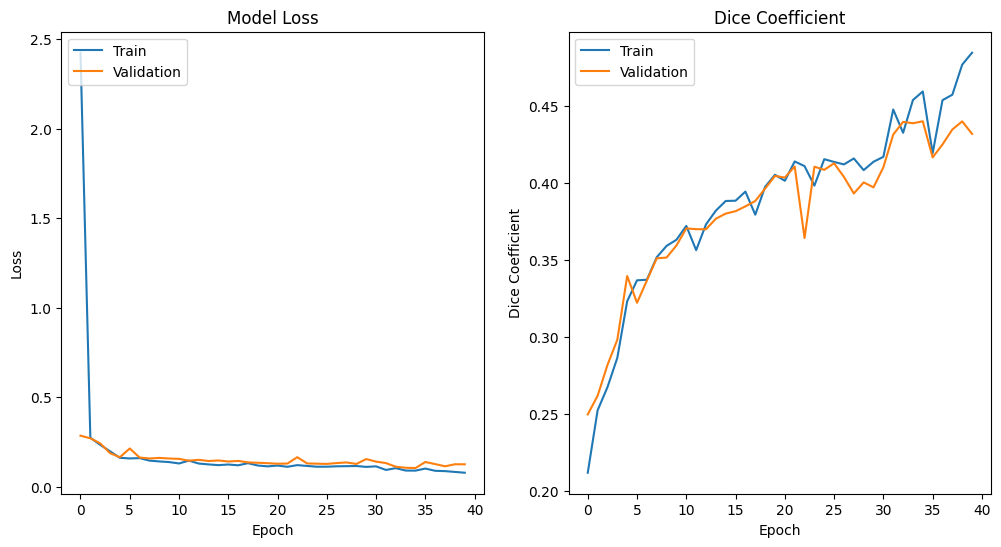

In [ ]:
with open('/content/gdrive/MyDrive/deep_learning_project/training_histories/base_model_history_1.json', 'r') as file:
    history_1 = json.load(file)

with open('/content/gdrive/MyDrive/deep_learning_project/training_histories/base_model_history_2.json', 'r') as file:
    history_2 = json.load(file)

for key in history_2:
    history_1[key].extend(history_2[key])


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_1['loss'])
plt.plot(history_1['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_1['dice_coefficient_multilabel'])
plt.plot(history_1['val_dice_coefficient_multilabel'])
plt.title('Dice Coefficient')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
model_combined_loss = unet_model_3d()
model_combined_loss.compile(optimizer='adam', loss=combined_dice_crossentropy_loss, metrics=[dice_coefficient_multilabel])

combined_loss_model_history = model_combined_loss.fit(train_img_datagen, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, validation_data=val_img_datagen, validation_steps=val_steps_per_epoch)

model_combined_loss.save('/content/gdrive/MyDrive/DLdata/model_combined_loss_20_epoch.keras')


Epoch 1/20
50/50 [==============================] - 883s 17s/step - loss: 3.6732 - dice_coefficient_multilabel: 0.2371 - val_loss: 0.4912 - val_dice_coefficient_multilabel: 0.2586
Epoch 2/20
50/50 [==============================] - 247s 5s/step - loss: 0.4581 - dice_coefficient_multilabel: 0.2861 - val_loss: 0.4653 - val_dice_coefficient_multilabel: 0.2890
Epoch 3/20
50/50 [==============================] - 266s 5s/step - loss: 0.4184 - dice_coefficient_multilabel: 0.3284 - val_loss: 0.4303 - val_dice_coefficient_multilabel: 0.3260
Epoch 4/20
50/50 [==============================] - 238s 5s/step - loss: 0.4064 - dice_coefficient_multilabel: 0.3409 - val_loss: 0.4352 - val_dice_coefficient_multilabel: 0.3259
Epoch 5/20
50/50 [==============================] - 227s 5s/step - loss: 0.4025 - dice_coefficient_multilabel: 0.3482 - val_loss: 0.3979 - val_dice_coefficient_multilabel: 0.3555
Epoch 6/20
50/50 [==============================] - 242s 5s/step - loss: 0.3916 - dice_coefficient_multi

In [ ]:
history_dict = combined_loss_model_history.history
history_json = json.dumps(history_dict)

with open('/content/gdrive/MyDrive/deep_learning_project/training_histories/combined_loss_model_history_1.json', 'w') as file:
    file.write(history_json)


In [ ]:
model_combined_loss_2 = load_model("/content/gdrive/MyDrive/DLdata/model_combined_loss_20_epoch.keras", custom_objects={"dice_coefficient_multilabel": dice_coefficient_multilabel, "combined_dice_crossentropy_loss": combined_dice_crossentropy_loss})

combined_loss_model_history_2 = model_combined_loss_2.fit(train_img_datagen, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, validation_data=val_img_datagen, validation_steps=val_steps_per_epoch)

model_combined_loss_2.save('/content/gdrive/MyDrive/DLdata/model_combined_loss_40_epoch.keras')


Epoch 1/20
50/50 [==============================] - 763s 14s/step - loss: 0.3648 - dice_coefficient_multilabel: 0.4115 - val_loss: 0.3898 - val_dice_coefficient_multilabel: 0.4001
Epoch 2/20
50/50 [==============================] - 252s 5s/step - loss: 0.3590 - dice_coefficient_multilabel: 0.4193 - val_loss: 0.4011 - val_dice_coefficient_multilabel: 0.3943
Epoch 3/20
50/50 [==============================] - 241s 5s/step - loss: 0.3545 - dice_coefficient_multilabel: 0.4259 - val_loss: 0.4039 - val_dice_coefficient_multilabel: 0.3982
Epoch 4/20
50/50 [==============================] - 250s 5s/step - loss: 0.3484 - dice_coefficient_multilabel: 0.4361 - val_loss: 0.4007 - val_dice_coefficient_multilabel: 0.3967
Epoch 5/20
50/50 [==============================] - 239s 5s/step - loss: 0.3512 - dice_coefficient_multilabel: 0.4391 - val_loss: 0.3952 - val_dice_coefficient_multilabel: 0.3999
Epoch 6/20
50/50 [==============================] - 242s 5s/step - loss: 0.3420 - dice_coefficient_multi

In [ ]:
history_dict = combined_loss_model_history_2.history
history_json = json.dumps(history_dict)

with open('/content/gdrive/MyDrive/deep_learning_project/training_histories/combined_loss_model_history_2.json', 'w') as file:
    file.write(history_json)


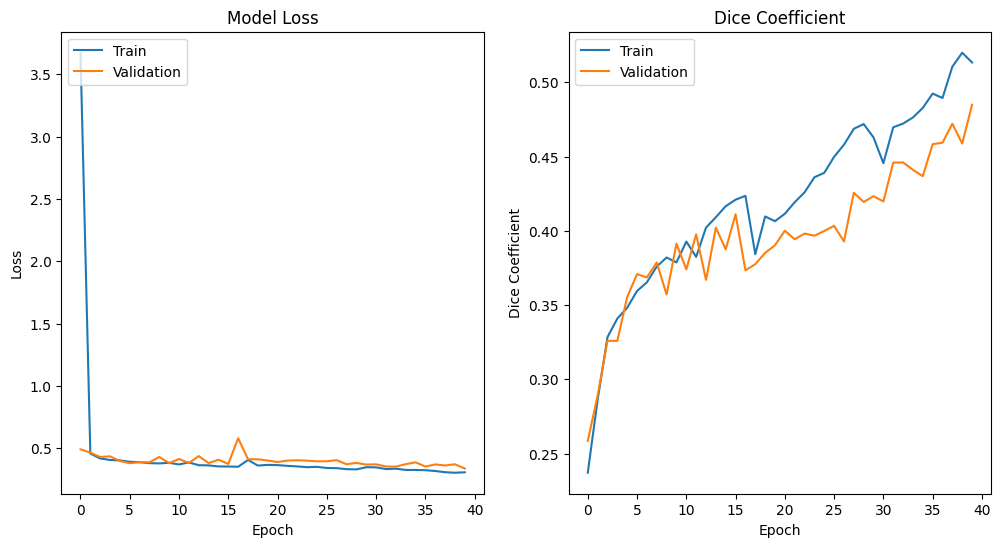

In [ ]:
with open('/content/gdrive/MyDrive/deep_learning_project/training_histories/combined_loss_model_history_1.json', 'r') as file:
    history_1 = json.load(file)

with open('/content/gdrive/MyDrive/deep_learning_project/training_histories/combined_loss_model_history_2.json', 'r') as file:
    history_2 = json.load(file)

for key in history_2:
    history_1[key].extend(history_2[key])


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_1['loss'])
plt.plot(history_1['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_1['dice_coefficient_multilabel'])
plt.plot(history_1['val_dice_coefficient_multilabel'])
plt.title('Dice Coefficient')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
model_lr_scheduler = unet_model_3d()
model_lr_scheduler.compile(optimizer='adam', loss=combined_dice_crossentropy_loss, metrics=[dice_coefficient_multilabel])

lr_scheduler_model_history = model_lr_scheduler.fit(train_img_datagen, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, validation_data=val_img_datagen, validation_steps=val_steps_per_epoch, callbacks=[lr_scheduler])

model_lr_scheduler.save('/content/gdrive/MyDrive/DLdata/model_lr_scheduler_20_epoch.keras')



Epoch 1: current learning rate is 0.0010000
Epoch 1/20
50/50 [==============================] - 563s 10s/step - loss: 0.9282 - dice_coefficient_multilabel: 0.2156 - val_loss: 0.8559 - val_dice_coefficient_multilabel: 0.1765

Epoch 2: current learning rate is 0.0001764
Epoch 2/20
50/50 [==============================] - 226s 5s/step - loss: 0.5015 - dice_coefficient_multilabel: 0.2632 - val_loss: 0.6387 - val_dice_coefficient_multilabel: 0.2380

Epoch 3: current learning rate is 0.0003564
Epoch 3/20
50/50 [==============================] - 228s 5s/step - loss: 0.4818 - dice_coefficient_multilabel: 0.2891 - val_loss: 0.6215 - val_dice_coefficient_multilabel: 0.2509

Epoch 4: current learning rate is 0.0005364
Epoch 4/20
50/50 [==============================] - 240s 5s/step - loss: 0.4509 - dice_coefficient_multilabel: 0.3187 - val_loss: 0.5539 - val_dice_coefficient_multilabel: 0.2909

Epoch 5: current learning rate is 0.0007164
Epoch 5/20
50/50 [==============================] - 240s 5

In [ ]:
history_dict = lr_scheduler_model_history.history
history_json = json.dumps(history_dict)

with open('/content/gdrive/MyDrive/deep_learning_project/training_histories/lr_scheduler_model_history_1.json', 'w') as file:
    file.write(history_json)


In [ ]:
model_lr_scheduler_2 = load_model("/content/gdrive/MyDrive/DLdata/model_lr_scheduler_20_epoch.keras", custom_objects={"dice_coefficient_multilabel": dice_coefficient_multilabel, "combined_dice_crossentropy_loss": combined_dice_crossentropy_loss})

lr_scheduler_model_history_2 = model_lr_scheduler_2.fit(train_img_datagen, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, validation_data=val_img_datagen, validation_steps=val_steps_per_epoch, callbacks=[lr_scheduler])

model_lr_scheduler_2.save('/content/gdrive/MyDrive/DLdata/model_lr_scheduler_40_epoch.keras')



Epoch 1: current learning rate is 0.0010000
Epoch 1/20
50/50 [==============================] - 296s 5s/step - loss: 0.2780 - dice_coefficient_multilabel: 0.5525 - val_loss: 0.4145 - val_dice_coefficient_multilabel: 0.4465

Epoch 2: current learning rate is 0.0005112
Epoch 2/20
50/50 [==============================] - 249s 5s/step - loss: 0.2820 - dice_coefficient_multilabel: 0.5487 - val_loss: 0.5583 - val_dice_coefficient_multilabel: 0.3953

Epoch 3: current learning rate is 0.0004710
Epoch 3/20
50/50 [==============================] - 232s 5s/step - loss: 0.2927 - dice_coefficient_multilabel: 0.5392 - val_loss: 0.4417 - val_dice_coefficient_multilabel: 0.4552

Epoch 4: current learning rate is 0.0004306
Epoch 4/20
50/50 [==============================] - 245s 5s/step - loss: 0.2688 - dice_coefficient_multilabel: 0.5670 - val_loss: 0.3513 - val_dice_coefficient_multilabel: 0.5102

Epoch 5: current learning rate is 0.0003904
Epoch 5/20
50/50 [==============================] - 246s 5s

In [ ]:
history_dict = lr_scheduler_model_history_2.history
history_json = json.dumps(history_dict)

with open('/content/gdrive/MyDrive/deep_learning_project/training_histories/lr_scheduler_model_history_2.json', 'w') as file:
    file.write(history_json)


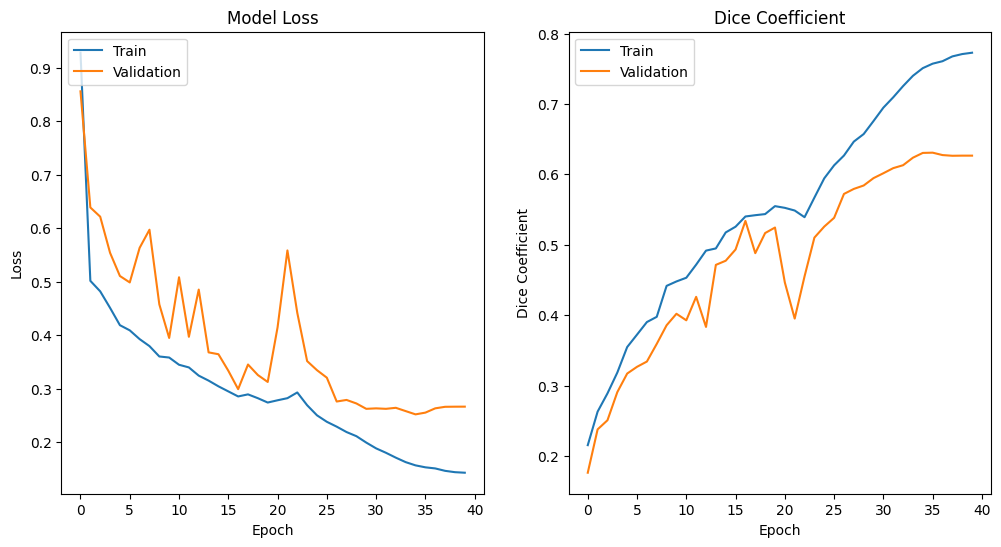

In [ ]:
with open('/content/gdrive/MyDrive/deep_learning_project/training_histories/lr_scheduler_model_history_1.json', 'r') as file:
    history_1 = json.load(file)

with open('/content/gdrive/MyDrive/deep_learning_project/training_histories/lr_scheduler_model_history_2.json', 'r') as file:
    history_2 = json.load(file)

for key in history_2:
    history_1[key].extend(history_2[key])


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_1['loss'])
plt.plot(history_1['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_1['dice_coefficient_multilabel'])
plt.plot(history_1['val_dice_coefficient_multilabel'])
plt.title('Dice Coefficient')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


# Test


In [ ]:
model = load_model("/content/gdrive/MyDrive/DLdata/model_lr_scheduler_40_epoch.keras", custom_objects={"dice_coefficient_multilabel": dice_coefficient_multilabel, "combined_dice_crossentropy_loss": combined_dice_crossentropy_loss})


In [ ]:
n_slice = 50

test_img, test_mask = test_img_datagen.__next__()

test_pred = model.predict(test_img)
test_pred_arg_max = np.argmax(test_pred, axis=4)[0,:,:,:]
seg_map_pred = test_pred_arg_max[:,:,n_slice]
test_mask_arg_max = np.argmax(test_mask, axis=4)[0,:,:,:]
seg_map_mask = test_mask_arg_max[:,:,n_slice]


1/1 [==============================] - 0s 227ms/step


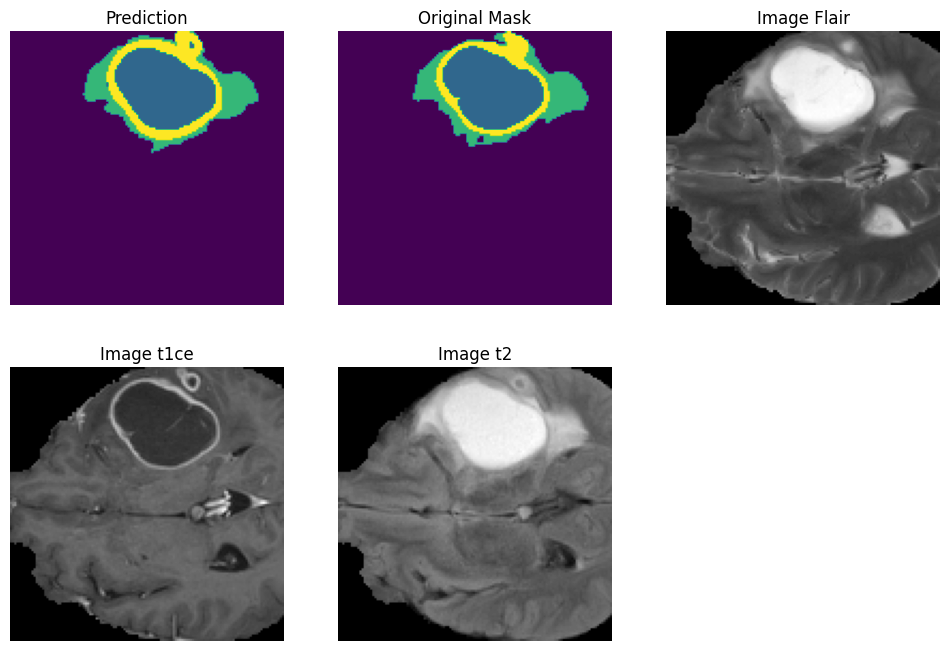

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Prediction')
plt.imshow(seg_map_pred)
plt.axis('off')

plt.subplot(232)
plt.title('Original Mask')
plt.imshow(seg_map_mask)
plt.axis('off')

plt.subplot(233)
plt.imshow(test_img[0,:, :, n_slice, 0], cmap='gray')
plt.title('Image Flair')
plt.axis('off')

plt.subplot(234)
plt.imshow(test_img[0,:, :, n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.axis('off')

plt.subplot(235)
plt.imshow(test_img[0,:, :, n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.axis('off')

plt.show()


# U-net with Batch Normalization

In [ ]:
def unet_model_3d_with_batch_norm(input_size=(128, 128, 128, 3), num_classes=4):
    inputs = Input(input_size)
    he_normal_init = HeNormal(seed=42)

    # Contraction path
    c1 = Conv3D(32, (3, 3, 3), kernel_initializer=he_normal_init, padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Dropout(0.3)(c1)
    c1 = Conv3D(32, (3, 3, 3), kernel_initializer=he_normal_init, padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(64, (3, 3, 3), kernel_initializer=he_normal_init, padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Dropout(0.3)(c2)
    c2 = Conv3D(64, (3, 3, 3), kernel_initializer=he_normal_init, padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(128, (3, 3, 3), kernel_initializer=he_normal_init, padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = Dropout(0.3)(c3)
    c3 = Conv3D(128, (3, 3, 3), kernel_initializer=he_normal_init, padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(256, (3, 3, 3), kernel_initializer=he_normal_init, padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4 = Dropout(0.4)(c4)
    c4 = Conv3D(256, (3, 3, 3), kernel_initializer=he_normal_init, padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    p4 = MaxPooling3D((2, 2, 2))(c4)

    c5 = Conv3D(512, (3, 3, 3), kernel_initializer=he_normal_init, padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    c5 = Dropout(0.5)(c5)
    c5 = Conv3D(512, (3, 3, 3), kernel_initializer=he_normal_init, padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)

    # Expansive path with concatenation
    u6 = UpSampling3D((2, 2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(256, (3, 3, 3), kernel_initializer=he_normal_init, padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    c6 = Dropout(0.4)(c6)
    c6 = Conv3D(256, (3, 3, 3), kernel_initializer=he_normal_init, padding='same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)

    u7 = UpSampling3D((2, 2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(128, (3, 3, 3), kernel_initializer=he_normal_init, padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = Dropout(0.4)(c7)
    c7 = Conv3D(128, (3, 3, 3), kernel_initializer=he_normal_init, padding='same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)

    u8 = UpSampling3D((2, 2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(64, (3, 3, 3), kernel_initializer=he_normal_init, padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    c8 = Dropout(0.3)(c8)
    c8 = Conv3D(64, (3, 3, 3), kernel_initializer=he_normal_init, padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)

    u9 = UpSampling3D((2, 2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(32, (3, 3, 3), kernel_initializer=he_normal_init, padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    c9 = Dropout(0.3)(c9)
    c9 = Conv3D(32, (3, 3, 3), kernel_initializer=he_normal_init, padding='same')(c9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


In [ ]:
base_model_with_batch_norm = unet_model_3d_with_batch_norm()
base_model_with_batch_norm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[dice_coefficient_multilabel])

base_model_with_batch_norm_history = base_model_with_batch_norm.fit(train_img_datagen, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, validation_data=val_img_datagen, validation_steps=val_steps_per_epoch)

base_model_with_batch_norm.save('/content/gdrive/MyDrive/DLdata/base_model_with_batch_norm_20_epoch.keras')


# Old Training

In [ ]:
# model = unet_model_3d()
# model.compile(optimizer='adam', loss=combined_dice_crossentropy_loss, metrics=[dice_coefficient_multilabel])

# history_1 = model.fit(train_img_datagen, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, validation_data=val_img_datagen, validation_steps=val_steps_per_epoch, callbacks=[lr_scheduler])

# model.save('/content/gdrive/MyDrive/DLdata/brats_3d_scheduler_20.keras')


Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 0.9357 - dice_coefficient_multilabel: 0.2143 
Epoch 1: current learning rate is 0.0001764
50/50 [==============================] - 745s 14s/step - loss: 0.9357 - dice_coefficient_multilabel: 0.2143 - val_loss: 0.8121 - val_dice_coefficient_multilabel: 0.1944
Epoch 2/20
50/50 [==============================] - ETA: 0s - loss: 0.5307 - dice_coefficient_multilabel: 0.2580
Epoch 2: current learning rate is 0.0003564
50/50 [==============================] - 250s 5s/step - loss: 0.5307 - dice_coefficient_multilabel: 0.2580 - val_loss: 0.5915 - val_dice_coefficient_multilabel: 0.2490
Epoch 3/20
50/50 [==============================] - ETA: 0s - loss: 0.4637 - dice_coefficient_multilabel: 0.2975
Epoch 3: current learning rate is 0.0005364
50/50 [==============================] - 252s 5s/step - loss: 0.4637 - dice_coefficient_multilabel: 0.2975 - val_loss: 0.7500 - val_dice_coefficient_multilabel: 0.2378
Epoch 4/20
50/50 [=====

In [ ]:
# base_model = load_model("/content/gdrive/MyDrive/DLdata/brats_3d_scheduler_20.keras", custom_objects={"dice_coefficient_multilabel": dice_coefficient_multilabel, "combined_dice_crossentropy_loss": combined_dice_crossentropy_loss})

# history_2 = base_model.fit(train_img_datagen, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, validation_data=val_img_datagen, validation_steps=val_steps_per_epoch, callbacks=[lr_scheduler])

# base_model.save('/content/gdrive/MyDrive/DLdata/brats_3d_scheduler_40.keras')



Epoch 1: current learning rate is 0.0010000
Epoch 1/20
50/50 [==============================] - 262s 5s/step - loss: 0.3010 - dice_coefficient_multilabel: 0.5192 - val_loss: 0.5341 - val_dice_coefficient_multilabel: 0.3721

Epoch 2: current learning rate is 0.0005112
Epoch 2/20
50/50 [==============================] - 262s 5s/step - loss: 0.2772 - dice_coefficient_multilabel: 0.5559 - val_loss: 0.6534 - val_dice_coefficient_multilabel: 0.3473

Epoch 3: current learning rate is 0.0004710
Epoch 3/20
50/50 [==============================] - 248s 5s/step - loss: 0.2867 - dice_coefficient_multilabel: 0.5501 - val_loss: 0.4848 - val_dice_coefficient_multilabel: 0.3887

Epoch 4: current learning rate is 0.0004306
Epoch 4/20
50/50 [==============================] - 237s 5s/step - loss: 0.2877 - dice_coefficient_multilabel: 0.5486 - val_loss: 0.6569 - val_dice_coefficient_multilabel: 0.3226

Epoch 5: current learning rate is 0.0003904
Epoch 5/20
50/50 [==============================] - 249s 5s

# Plots for report

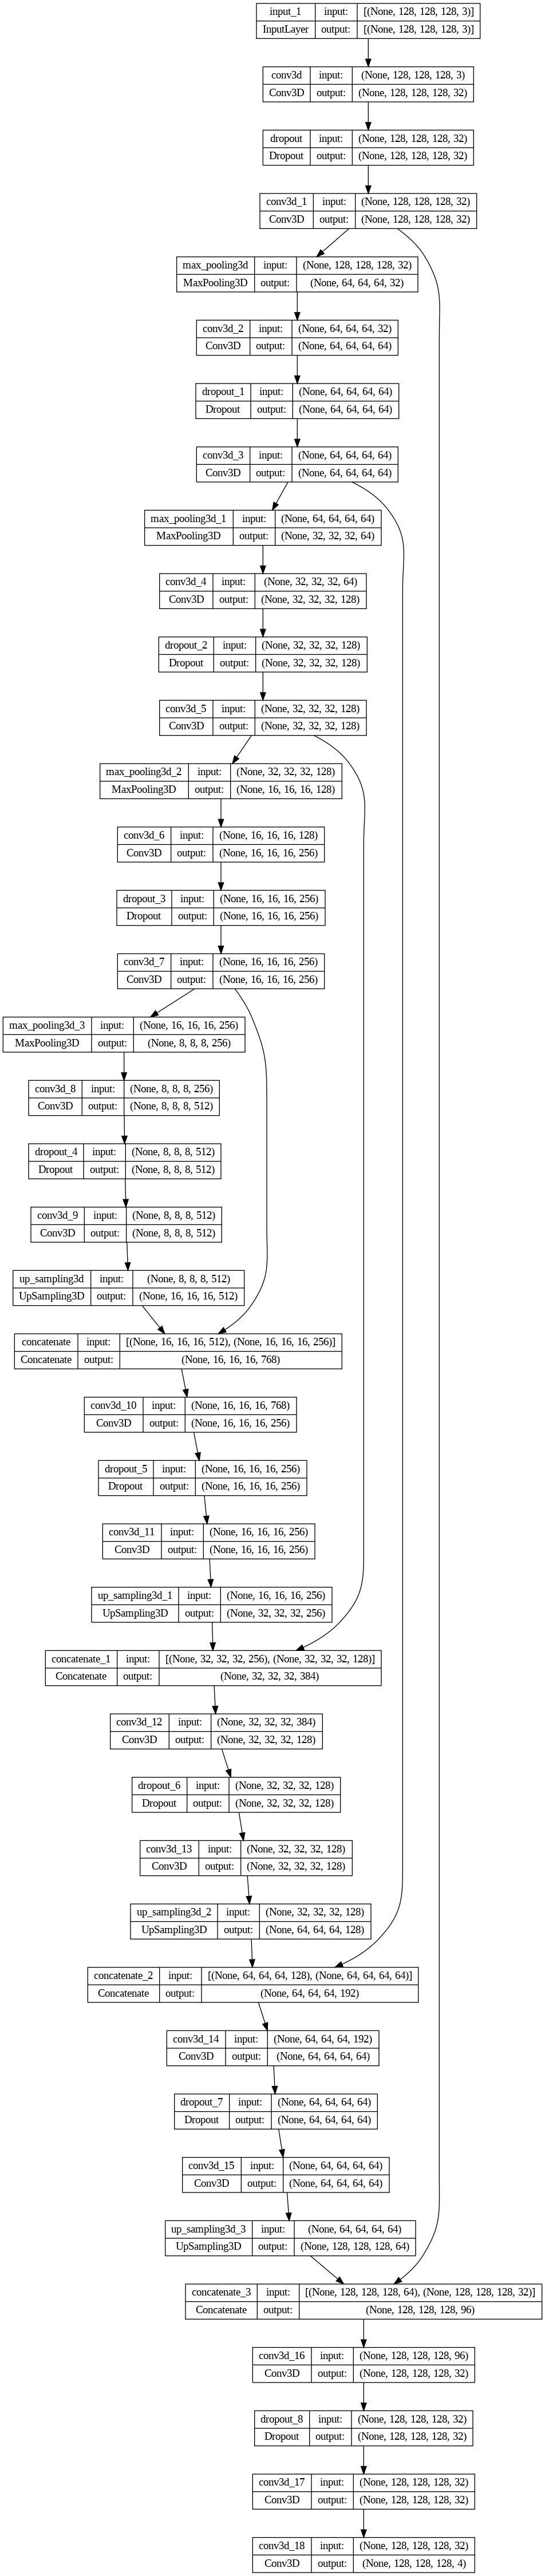

In [ ]:
model = unet_model_3d()
plot_model(model, to_file='unet_model_plot.png', show_shapes=True, show_layer_names=True)

[98.80184733  0.15636089  0.79363542  0.24815636]


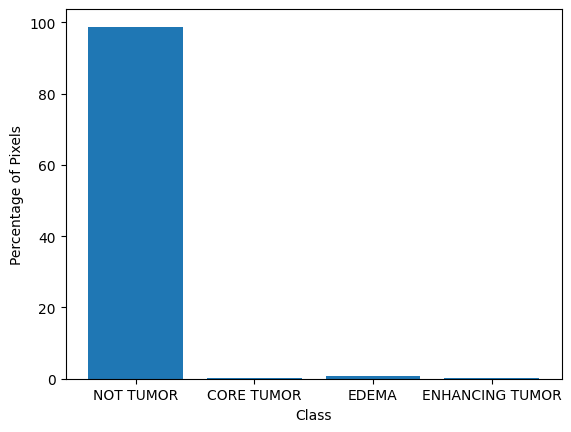

In [ ]:
SEGMENT_CLASSES = {
    0: 'NOT TUMOR',
    1: 'CORE TUMOR',
    2: 'EDEMA',
    3: 'ENHANCING TUMOR'
}

def load_img_and_count_pixels(img_dir, img_list):
    class_pixel_counts = np.zeros(len(SEGMENT_CLASSES))
    slice_count = 0
    total_pixels_per_slice = []

    for image_name in img_list:
        if '_seg' in image_name:
            mask = nib.load(image_name).get_fdata()
            mask[mask == 4] = 3

            for slice_idx in range(mask.shape[2]):
                slice_mask = mask[:, :, slice_idx]

                total_pixels = slice_mask.size
                total_pixels_per_slice.append(total_pixels)

                for i in range(len(SEGMENT_CLASSES)):
                    class_pixel_counts[i] += np.count_nonzero(slice_mask == i)

            slice_count += mask.shape[2]

    average_pixels = (class_pixel_counts / sum(total_pixels_per_slice)) * 100
    return average_pixels


avg_train_pixels = load_img_and_count_pixels(train_mask_dir, train_mask_list)

print(avg_train_pixels)
index = np.arange(len(SEGMENT_CLASSES))
plt.bar(index, avg_train_pixels)
plt.xlabel('Class')
plt.ylabel('Percentage of Pixels')
plt.xticks(index, [SEGMENT_CLASSES[i] for i in range(len(SEGMENT_CLASSES))])
plt.gca().ticklabel_format(style='plain', axis='y')
plt.show()
